<a href="https://colab.research.google.com/github/lephuocdat2000/-CS114.K21-/blob/master/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo pip install mtcnn
import mtcnn
print(mtcnn.__version__)

Using TensorFlow backend.


0.1.0


In [2]:
from PIL import Image
from mtcnn.mtcnn import MTCNN
import pandas as pd
import numpy as np 
from numpy import savez_compressed
from numpy import asarray
from numpy import expand_dims
from os import listdir
from os.path import isdir
import matplotlib.pyplot as plt


In [3]:
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
main_folder='/content/drive/My Drive/Final_Project/'
images_folder=main_folder + 'face/'
df_attr=pd.read_excel(main_folder+'gender_dataset.xlsx',)

In [6]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	for filename in list(directory):
		path=images_folder + filename
		face = extract_face(path)
		faces.append(face)
	return faces

In [7]:
from sklearn.model_selection import train_test_split
x=df_attr['Id_image']
y=df_attr['Male']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
arr_faces_train=load_faces(x_train)

In [8]:
arr_faces_test=load_faces(x_test)
savez_compressed('faces-dataset.npz', arr_faces_train, y_train, arr_faces_test, y_test)

Face Embedding

In [11]:
from keras.models import load_model
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
  
data=np.load('faces-dataset.npz')
trainX,trainY,testX,testY=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print('Loaded: ', trainX.shape, trainY.shape, testX.shape, testY.shape)
model = load_model('facenet_keras.h5')
print('Loaded Model')
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainY, newTestX, testY)



Loaded:  (1600, 160, 160, 3) (1600,) (400, 160, 160, 3) (400,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(1600, 128)
(400, 128)


StandardScaler 


In [13]:
# load dataset
data = np.load('faces-embeddings.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
from sklearn.preprocessing import Normalizer
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [16]:
trainY

array([1, 0, 0, ..., 1, 0, 1])

In [17]:
from sklearn.svm import SVC
model=SVC(kernel='linear')
model.fit(trainX,trainY)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
predict_train=model.predict(trainX)

In [19]:
predict_y=model.predict(testX)

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(testY, predict_y))
accuracy_score(trainY,predict_train)

0.82


0.849375

In [38]:
import random
data = np.load('faces-dataset.npz')
testX_faces = data['arr_2']
selection = random.choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testY[selection]
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)


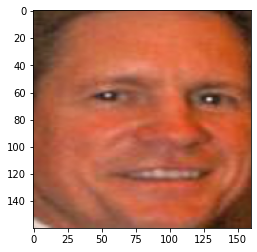

In [39]:
image = Image.fromarray(random_face_pixels)
plt.imshow(image)

In [41]:
from sklearn.model_selection import GridSearchCV
param_grid={
             'kernel':['linear','rbf','poly'],
            }
search=GridSearchCV(model,param_grid,n_jobs=-1)
search.fit(testX,testY)
search.best_params_

{'kernel': 'rbf'}